In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
data_postulantes = pd.read_csv('data-tp/postulantes_genero_edad_limpio.csv')
data_vistas = pd.read_csv('data-tp/vistas_limpio.csv')
data_detalles = pd.read_csv('data-tp/avisos_detalles.csv')

In [3]:
postulantes_vistas = pd.merge(data_postulantes, data_vistas, on='idpostulante', how= 'inner')

In [4]:
postulantes_vistas['fecha_nacimiento_dt'] = pd.to_datetime(postulantes_vistas['fechanacimiento'], errors= 'coerce')
postulantes_vistas['age'] = postulantes_vistas['fecha_nacimiento_dt'].apply(lambda x: 2018 - x.year)


In [5]:
#vistas_counts = postulantes_vistas['idpostulante'].value_counts().to_frame()
#postulantes_vistas_sd = postulantes_vistas.drop_duplicates('idpostulante')
postulantes_vistas_count = postulantes_vistas.groupby(['idpostulante', 'age']).count().reset_index()

In [6]:
postulantes_vistas_count = postulantes_vistas_count[['idpostulante','age','fechanacimiento']]
postulantes_vistas_count.columns = ['id_postulante','age','avisos_vistos']

In [7]:
postulantes_avisos_mean = postulantes_vistas_count.groupby('age').mean().reset_index()
postulantes_avisos_mean.columns = ['age','avisos_vistos_mean']

### Cantidad de avisos vistos disminuye de acuerdo a la edad

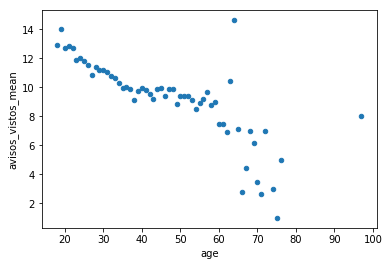

In [8]:
%matplotlib inline
postulantes_avisos_mean.plot.scatter('age','avisos_vistos_mean')


In [9]:
postulantes_vistas_detalles = postulantes_vistas.merge(data_detalles, on = 'idAviso', how = 'inner')

### Dividimos el siguiente grafico en 6 partes. Un unico grafico gigante es inmanejable y no hay problema con analizarlo por separado. Observando los gráficos podemos reafirmar el dato anterior obtenido. La cantidad de vistas disminuye de acuerdo a la edad. Lo que podemos garantizar es que este comportamiento es análogo a todas las áreas. Las personas entre ~20 y ~30 años son las que más miran avisos. Y las areas más vistas son: Administracion, Atención al cliente, Call center, Comercial, Farmaceutica, Finanzas, Gastronomia, Legal, Logística, Produccion, Recepcionista, Ventas.

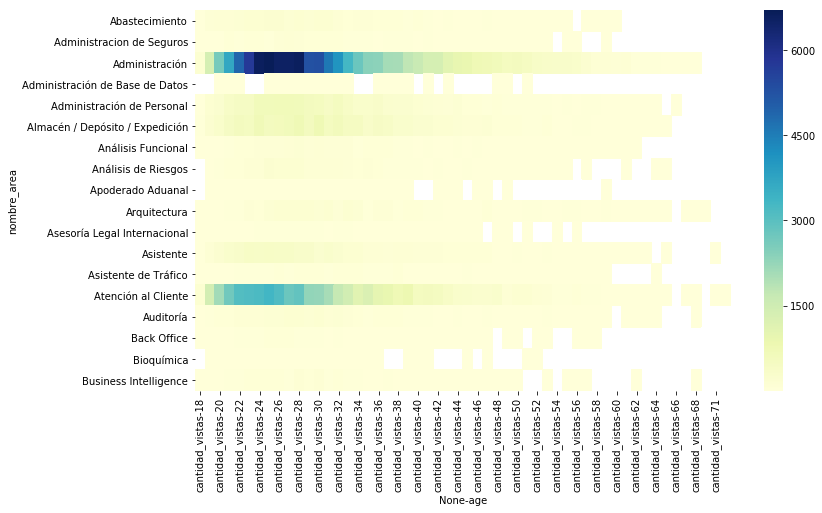

In [10]:
avisos_edad_area = postulantes_vistas_detalles.groupby(['nombre_area','age'])\
                    .count().reset_index()[['nombre_area','age','idpostulante']]
avisos_edad_area.columns = ['nombre_area','age','cantidad_vistas']
avisos_edad_area['cantidad_vistas'] = pd.to_numeric(avisos_edad_area['cantidad_vistas'])
avisos_edad_area['age'] = pd.to_numeric(avisos_edad_area['age'], errors='coerce')
avisos_edad_area_lc = avisos_edad_area[(avisos_edad_area['nombre_area'].str.lower() < 'c')]
plt.figure(figsize = (12,7))
sns.heatmap(avisos_edad_area_lc.pivot_table(index='nombre_area', columns = 'age'), cmap="YlGnBu")

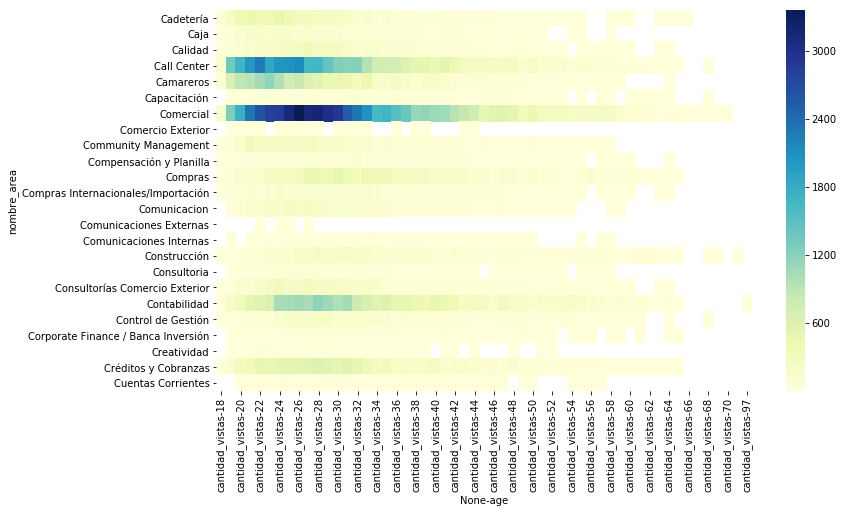

In [11]:
avisos_edad_area_gc_ld = avisos_edad_area[(avisos_edad_area['nombre_area'].str.lower() >= 'c') & (avisos_edad_area['nombre_area'].str.lower() < 'd')]
plt.figure(figsize = (12,7))
sns.heatmap(avisos_edad_area_gc_ld.pivot_table(index='nombre_area', columns = 'age'), cmap="YlGnBu")

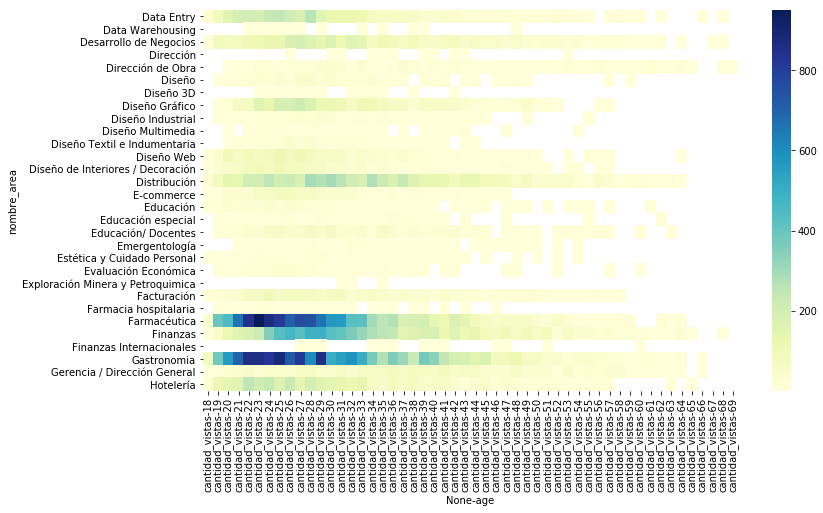

In [12]:
avisos_edad_area_gd_li = avisos_edad_area[(avisos_edad_area['nombre_area'].str.lower() >= 'd') & (avisos_edad_area['nombre_area'].str.lower() < 'i')]
plt.figure(figsize = (12,7))
sns.heatmap(avisos_edad_area_gd_li.pivot_table(index='nombre_area', columns = 'age'), cmap="YlGnBu")

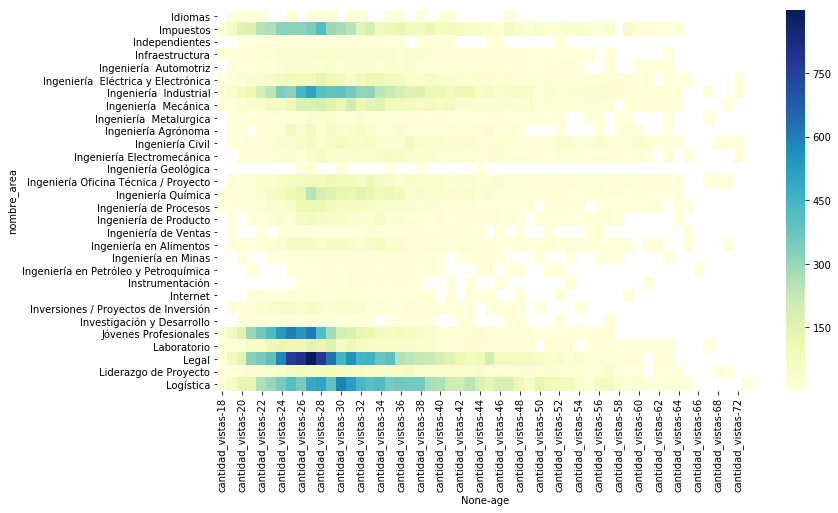

In [13]:
avisos_edad_area_gi_lm = avisos_edad_area[(avisos_edad_area['nombre_area'].str.lower() >= 'i') & (avisos_edad_area['nombre_area'].str.lower() < 'm')]
plt.figure(figsize = (12,7))
sns.heatmap(avisos_edad_area_gi_lm.pivot_table(index='nombre_area', columns = 'age'), cmap="YlGnBu")

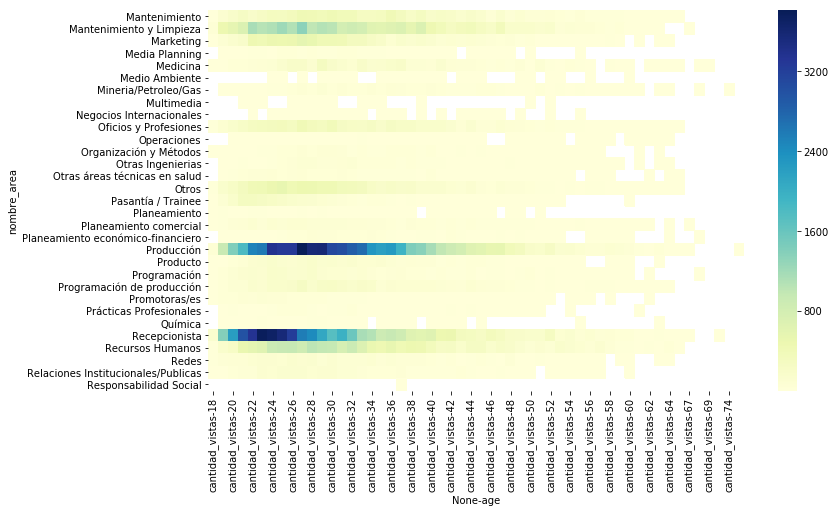

In [14]:
avisos_edad_area_gm_ls = avisos_edad_area[(avisos_edad_area['nombre_area'].str.lower() >= 'm') & (avisos_edad_area['nombre_area'].str.lower() < 's')]
plt.figure(figsize = (12,7))
sns.heatmap(avisos_edad_area_gm_ls.pivot_table(index='nombre_area', columns = 'age'), cmap="YlGnBu")

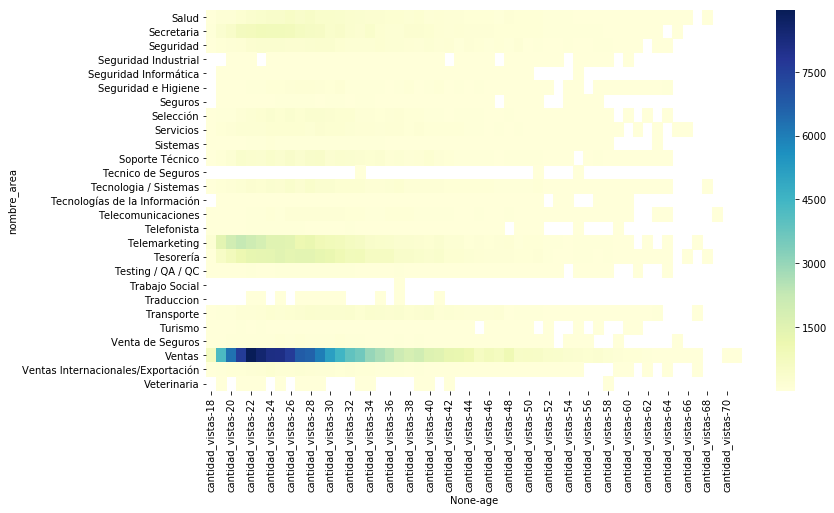

In [15]:
avisos_edad_area_gs = avisos_edad_area[(avisos_edad_area['nombre_area'].str.lower() >= 's') ]
plt.figure(figsize = (12,7))
sns.heatmap(avisos_edad_area_gs.pivot_table(index='nombre_area', columns = 'age'), cmap="YlGnBu")

## Grafico la cantidad de avisos promedio de la gente menor a 40 años, discriminado por sexo.

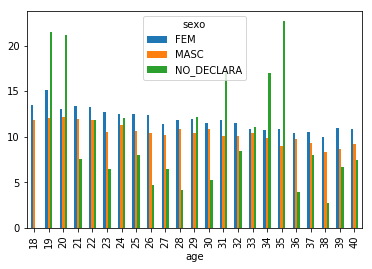

In [16]:
postulantes_sexo_edad = postulantes_vistas.groupby(['idpostulante', 'sexo','age']).count().reset_index()[['sexo','idAviso','age']]
postulantes_sexo_edad_men_30 = postulantes_sexo_edad[postulantes_sexo_edad['age'] <= 40]
postulantes_sexo_edad_men_30 = postulantes_sexo_edad_men_30.groupby(['sexo','age']).mean().reset_index()
postulantes_sexo_edad_men_30.columns = ['sexo','age','mean']
postulantes_sexo_edad_men_30.pivot(index = 'age', columns = 'sexo', values = 'mean').plot(kind='bar')

# El plot quedo gigante, quizas se puede particionar mas todavia.

## idem arriba, para la gente entre 40-70 años.

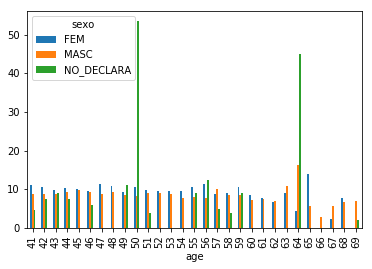

In [17]:
postulantes_sexo_edad_men_70 = postulantes_sexo_edad[(postulantes_sexo_edad['age'] > 40) & (postulantes_sexo_edad['age']<70)]
postulantes_sexo_edad_men_70 = postulantes_sexo_edad_men_70.groupby(['sexo','age']).mean().reset_index()
postulantes_sexo_edad_men_70.columns = ['sexo','age','mean']
postulantes_sexo_edad_men_70.pivot(index = 'age', columns = 'sexo', values = 'mean').plot(kind='bar')

In [18]:
data_carreras = pd.read_csv('data/fiuba_1_postulantes_educacion.csv',error_bad_lines=False)


## Obtengo el titulo mas "alto" de cada id.

In [19]:
carrers_by_priority = ['Secundario','Terciario/Técnico','Otro','Universitario','Posgrado','Master','Doctorado']
def get_higher_carrer(serie):
    high = 0
    for index in range(len(carrers_by_priority)):
        for carrer in serie['nombre']:
            if(carrers_by_priority[index] == carrer):
                high = index if index > high else high
    return carrers_by_priority[high]

data_carreras_fil = data_carreras.groupby('idpostulante').agg(get_higher_carrer).reset_index()[['idpostulante','nombre']]

In [20]:
data_carreras_fil = data_carreras.merge(data_carreras_fil, how = 'left', on=['idpostulante','nombre'])

In [21]:
data_carreras_univ = data_carreras_fil[data_carreras_fil['nombre'] == 'Universitario']


## ¿Buscan más trabajo las personas que están estudiando una carrera o los que se graduaron?

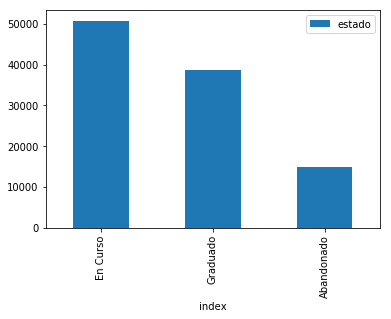

In [22]:
data_carreras_univ['estado'].value_counts().to_frame().reset_index().plot.bar(x='index',y='estado')

### Hagamos el mismo analisis que el anterior, pero discriminado por areas (Imposible ver, se me muere la pc )

In [23]:
#  data_carreras_fil = data_carreras.merge(data_carreras_fil, how = 'left', on=['idpostulante','nombre'])\
#                                   .merge(data_vistas, on='idpostulante', how='inner')\
#                                   .merge(data_detalles, on='idAviso)
# data_carreras_fil.head()

### Busco cuales son las empresas con mas avisos vistos

In [24]:
postulantes_vistas_detalles = postulantes_vistas.merge(data_detalles, on = 'idAviso', how ='inner')

In [25]:
empresas_por_avisos = postulantes_vistas_detalles.groupby('denominacion_empresa').count().reset_index()[['denominacion_empresa','idpostulante']]

In [26]:
empresas_por_avisos.columns = ['denominacion_empresa','cantidad_avisos']
top_ten_avisos_empresas = empresas_por_avisos.sort_values(by='cantidad_avisos', ascending = False)[:10]['denominacion_empresa']

In [27]:
postulantes_sexo_area = postulantes_vistas_detalles[(postulantes_vistas_detalles['denominacion_empresa'].isin(top_ten_avisos_empresas))]
postulantes_sexo_area = postulantes_sexo_area.groupby(['denominacion_empresa','sexo']).count().reset_index()[['denominacion_empresa','sexo','idpostulante']]

In [28]:
postulantes_sexo_area.columns = ['denominacion_empresa','sexo','cantidad_postulantes']

## La distribucion de genero entre las 10 empresas con mas avisos es bastante igualitaria. (Recordar, son los avisos vistos por las personas, no el resultado final de contratacion)

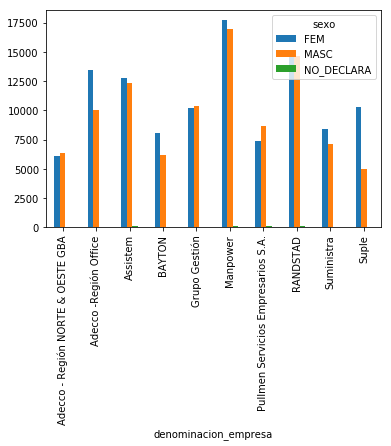

In [29]:
postulantes_sexo_area.pivot(index = 'denominacion_empresa', columns= 'sexo', values='cantidad_postulantes').plot(kind='bar')

### Esto me da la sugerencia de que las empresas "mas grandes" son las mas igualitaria. Vamos a evaluar usando un scatter plot la relacion y si es cierto

In [30]:
postulantes_sexo_area = postulantes_vistas_detalles.groupby(['denominacion_empresa','sexo']).count().reset_index()[['denominacion_empresa','sexo','idpostulante']]

In [31]:
postulantes_sexo_area = postulantes_sexo_area.pivot_table(index='denominacion_empresa', columns='sexo',values='idpostulante')

In [32]:
postulantes_sexo_area['delta_sex'] = (abs(postulantes_sexo_area['FEM'] - postulantes_sexo_area['MASC'])) / (postulantes_sexo_area['FEM'] + postulantes_sexo_area['MASC'])

In [33]:
empresas_vistas_delta_sex = postulantes_sexo_area.reset_index().merge(empresas_por_avisos, on= 'denominacion_empresa', how = 'inner')

### Podemos observar que para las empresas con poca cantidad de vistas el delta sex es bastante variable. Pero para las empresas con mas de 5000 avisos vistos la cantidad de hombres y mujeres que ven los anuncios se aproxima a ser equitativo. ¿A qué se debe esto? ¿A que las empresas "mas grandes" (con mas avisos online) tienden a ser más inclusivos en su propuesta tal que llaman la atencion de ambos sexos?  

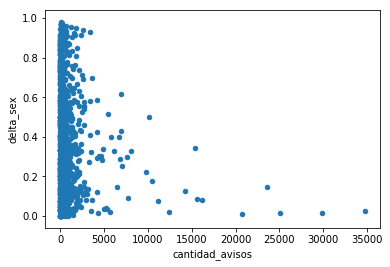

In [34]:
empresas_vistas_delta_sex[empresas_vistas_delta_sex['cantidad_avisos'] > 10]\
                        .plot.scatter(x='cantidad_avisos', y='delta_sex')

### En el siguiente bloxplot. Podemos observar que los datos estan distribuidos de forma simetrica. El 50% de los datos (Por debajo del segundo cuartil) se encuentran entre los valores ~0.35 y ~0.0 . Lo cual nos permite deducir que en el %50 de las empresas, los avisos resultan interesantes para ambos sexos. Sin embargo, entre lo valores ~0.6 y ~1.0 se encuentran el %25 de las empresas. Es decir, en la balanza entre los generos que miran los avisos esta bastante desbalanceada. ¿A qué se debe? ¿Será por el área al cual se enfocan estas empresas?

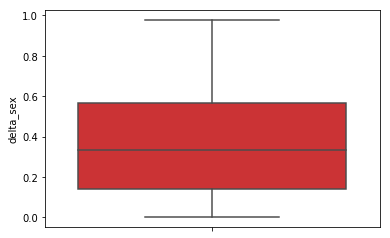

In [35]:
# postulantes_sexo_area = postulantes_sexo_area.reset_index()
# postulantes_sexo_area['delta_sex'].to_frame().boxplot('delta_sex')
sns.boxplot(y = 'delta_sex', data = postulantes_sexo_area, palette='Set1')

### Vamos a analizar cuales son las areas a la que se dedican las empresas que tienen más del 0.5 de delta_sex

In [36]:
vistas_delta_sex_25_percent = postulantes_sexo_area[postulantes_sexo_area['delta_sex'] > 0.5].reset_index()

In [37]:
empresas_delta_sex_25_percent = vistas_delta_sex_25_percent.merge(data_detalles.drop_duplicates(subset ='denominacion_empresa'), on='denominacion_empresa', how='inner') \
                                .reset_index()\
                                [['nombre_area','denominacion_empresa']]

### La mayoria de las empresas que superan el 0.5 en la escala de desigualdad de genero parecen pertenecer al sector de ventas. Averiguemos cual es el genero que mas esta interesado en esta area

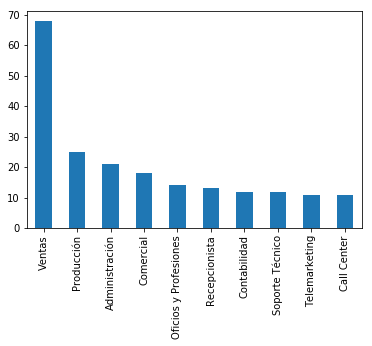

In [38]:
empresas_delta_sex_25_percent['nombre_area'].value_counts().head(10).plot.bar()

In [39]:
postulantes_ventas = postulantes_vistas_detalles[postulantes_vistas_detalles['nombre_area'] == 'Ventas']

### Con el siguiente grafico. Concluimos que el sexo más interesado en el area de ventas, area donde hay mayor desigualdad de genero, es el sexo femenino.

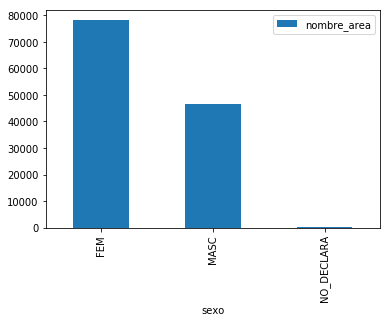

In [40]:
postulantes_ventas[['nombre_area','sexo']].groupby('sexo').count().plot.bar()

In [41]:
empresas_avisos_nivel = postulantes_vistas_detalles.groupby(['denominacion_empresa', 'nivel_laboral'])\
                                                    .count().reset_index()[['denominacion_empresa', 'nivel_laboral', 'idpostulante']]
empresas_avisos_nivel.columns = ['denominacion_empresa', 'nivel_laboral', 'cantidad_vistas']

In [42]:
empresas_avisos_nivel = empresas_avisos_nivel[empresas_avisos_nivel ['cantidad_vistas'] > 1000]

### Podemos observar mediante los siguientes graficos cuales son las empresas más llamativas de acuerdo al nivel laboral de cada postulante. Por ejemplo, los postulantes con nivel junior suelen mirar las publicaciones de BBVA Francés, Deloitte, EAYA , Universidad de Palermo, YVYV S.A., entre otros.

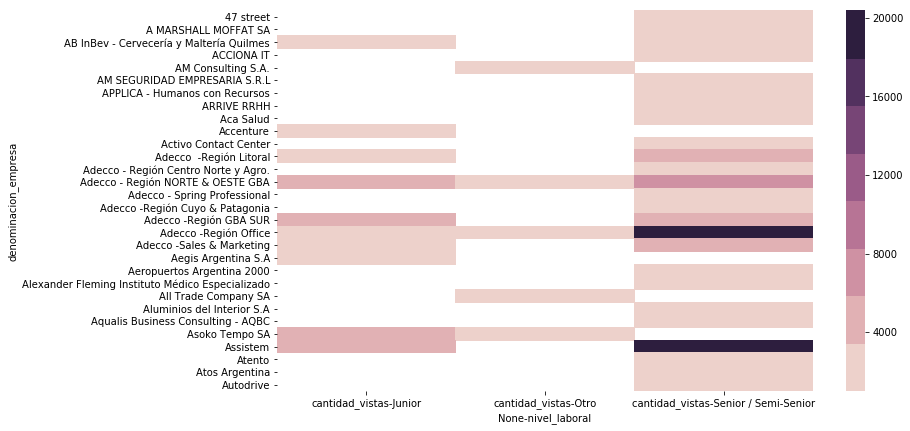

In [43]:
empresas_avisos_nivel_lb = empresas_avisos_nivel[empresas_avisos_nivel['denominacion_empresa'].str.lower() < 'b']
plt.figure(figsize = (12,7))
sns.heatmap(empresas_avisos_nivel_lb.pivot_table(index = 'denominacion_empresa', columns = 'nivel_laboral'), cmap=sns.cubehelix_palette(8))

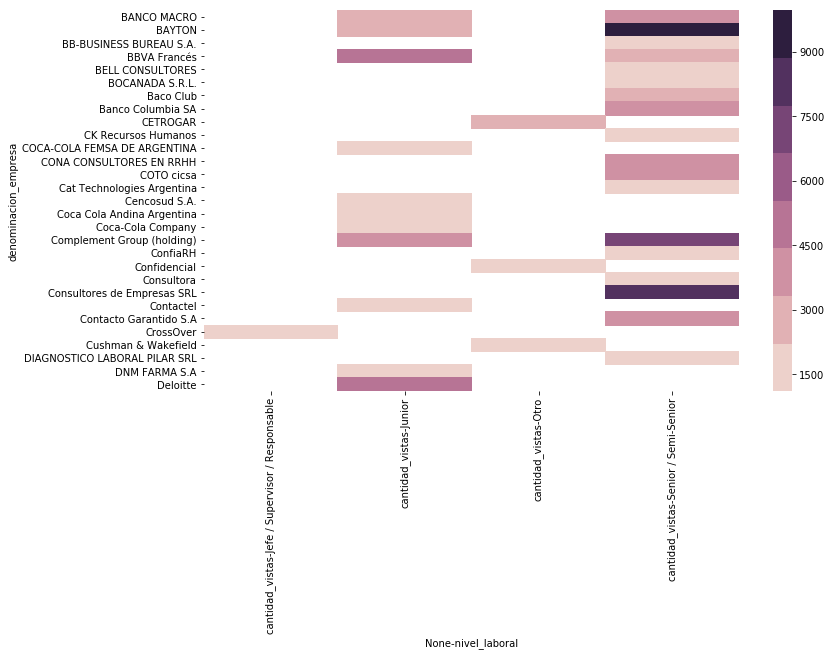

In [44]:
empresas_avisos_nivel_gb_le = empresas_avisos_nivel[(empresas_avisos_nivel['denominacion_empresa'].str.lower() >= 'b') & (empresas_avisos_nivel['denominacion_empresa'].str.lower() < 'e')]
plt.figure(figsize = (12,7))
sns.heatmap(empresas_avisos_nivel_gb_le.pivot_table(index = 'denominacion_empresa', columns = 'nivel_laboral'), cmap=sns.cubehelix_palette(8))

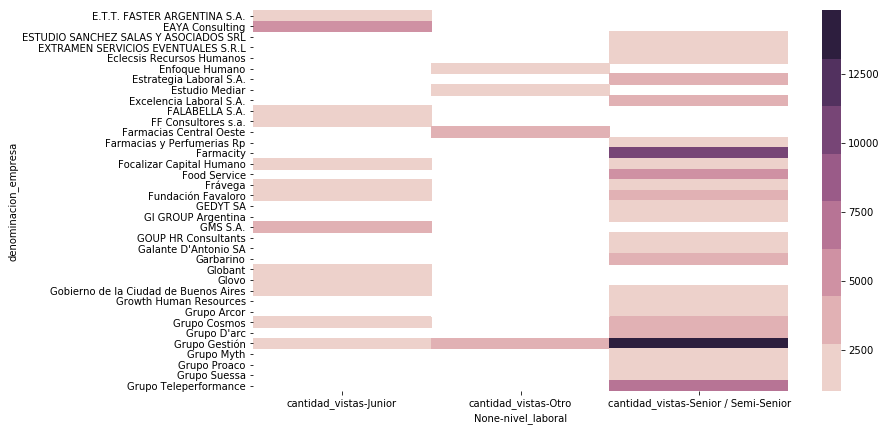

In [45]:
empresas_avisos_nivel_gas = empresas_avisos_nivel[(empresas_avisos_nivel['denominacion_empresa'].str.lower() >= 'e') & (empresas_avisos_nivel['denominacion_empresa'].str.lower() < 'h')]
plt.figure(figsize = (12,7))
sns.heatmap(empresas_avisos_nivel_gas.pivot_table(index = 'denominacion_empresa', columns = 'nivel_laboral'), cmap=sns.cubehelix_palette(8))

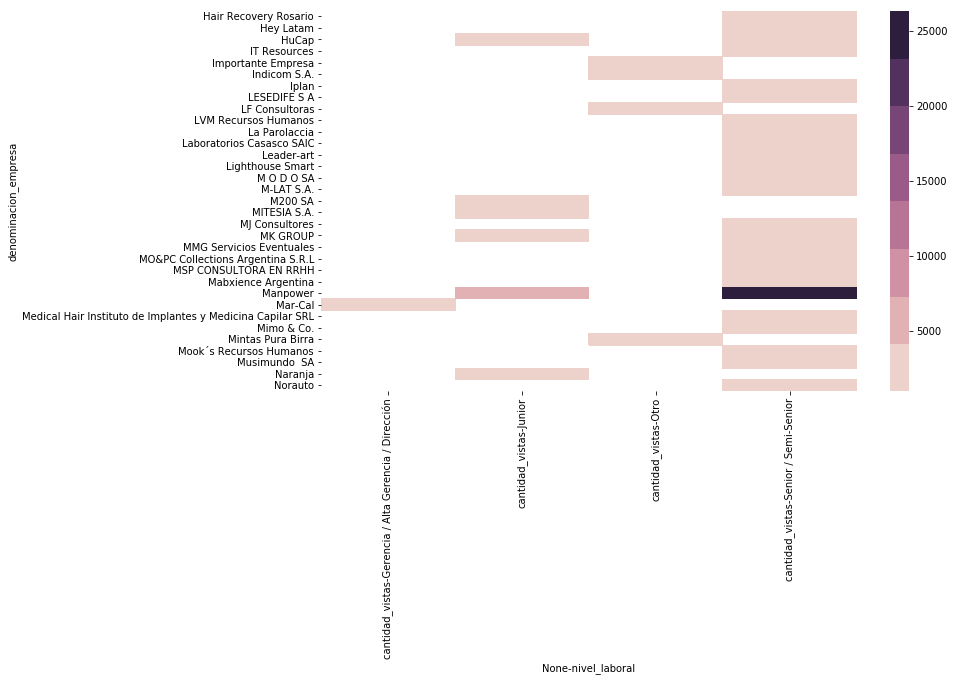

In [46]:
empresas_avisos_nivel_gh_lo = empresas_avisos_nivel[(empresas_avisos_nivel['denominacion_empresa'].str.lower() >= 'h') & (empresas_avisos_nivel['denominacion_empresa'].str.lower() < 'o')]
plt.figure(figsize = (12,7))
sns.heatmap(empresas_avisos_nivel_gh_lo.pivot_table(index = 'denominacion_empresa', columns = 'nivel_laboral'), cmap=sns.cubehelix_palette(8))

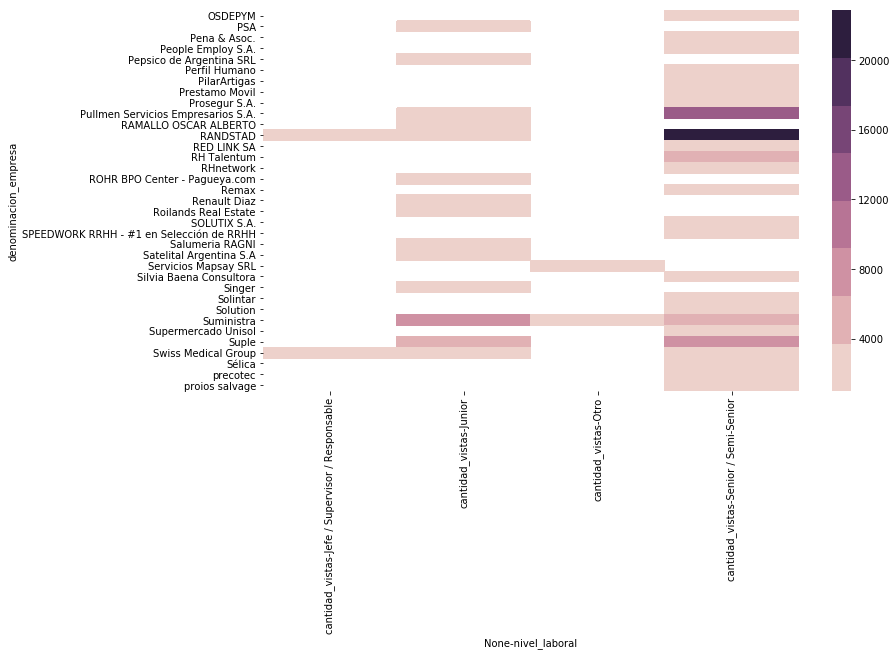

In [47]:
empresas_avisos_nivel_go_lt = empresas_avisos_nivel[(empresas_avisos_nivel['denominacion_empresa'].str.lower() >= 'o') & (empresas_avisos_nivel['denominacion_empresa'].str.lower() < 't')]
plt.figure(figsize = (12,7))
sns.heatmap(empresas_avisos_nivel_go_lt.pivot_table(index = 'denominacion_empresa', columns = 'nivel_laboral'), cmap=sns.cubehelix_palette(8))

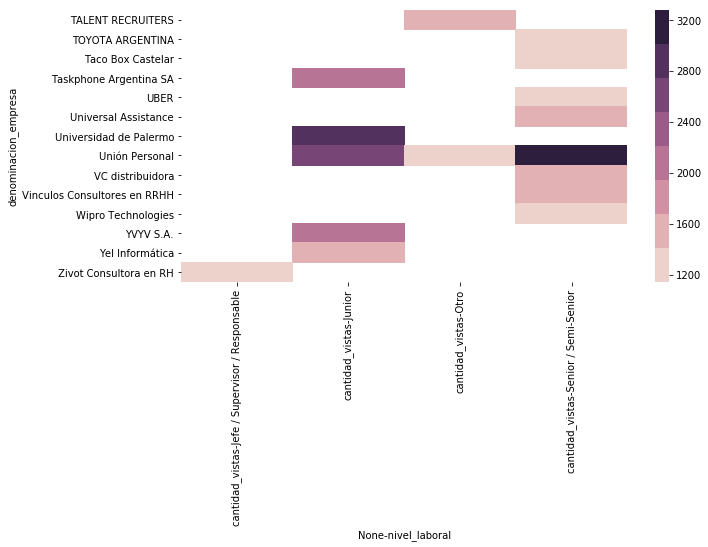

In [48]:
empresas_avisos_nivel_gt = empresas_avisos_nivel[(empresas_avisos_nivel['denominacion_empresa'].str.lower() >= 't')]
plt.figure(figsize = (10,5))
sns.heatmap(empresas_avisos_nivel_gt.pivot_table(index = 'denominacion_empresa', columns = 'nivel_laboral'), cmap=sns.cubehelix_palette(8))

In [49]:
detalles_tipo_trabajo = data_detalles.groupby(['denominacion_empresa','tipo_de_trabajo']).count().reset_index()[['denominacion_empresa','tipo_de_trabajo','idAviso']]
detalles_tipo_trabajo.columns = ['denominacion_empresa','tipo_de_trabajo','cantidad_avisos_tipo_trabajo']

### Veamos que tipos de trabajos son las que mas buscan las empresas

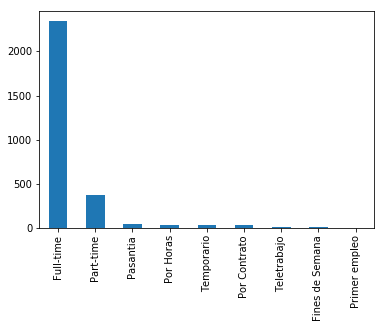

In [50]:
detalles_tipo_trabajo['tipo_de_trabajo'].value_counts().plot.bar()

### Busquemos cuales son las empresas con mas avisos part time

In [51]:
detalles_tipo_trabajo_part = detalles_tipo_trabajo[detalles_tipo_trabajo['tipo_de_trabajo'] == 'Part-time']

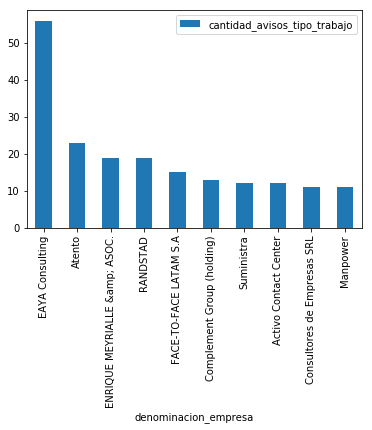

In [52]:
top_ten_empresas_part = detalles_tipo_trabajo_part.sort_values(by='cantidad_avisos_tipo_trabajo',ascending=False)[:10]
top_ten_empresas_part.plot.bar(x = 'denominacion_empresa', y='cantidad_avisos_tipo_trabajo')

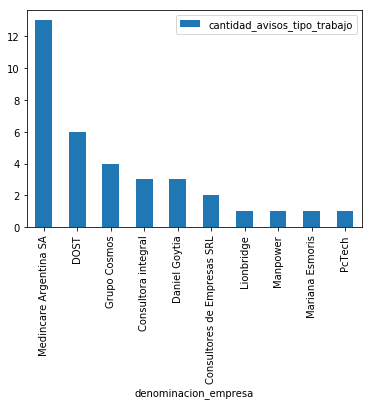

In [53]:
detalles_tipo_trabajo_hora = detalles_tipo_trabajo[detalles_tipo_trabajo['tipo_de_trabajo'] == 'Por Horas']
top_ten_empresas_hora= detalles_tipo_trabajo_hora.sort_values(by='cantidad_avisos_tipo_trabajo',ascending=False)[:10]
top_ten_empresas_hora.plot.bar(x = 'denominacion_empresa', y='cantidad_avisos_tipo_trabajo')

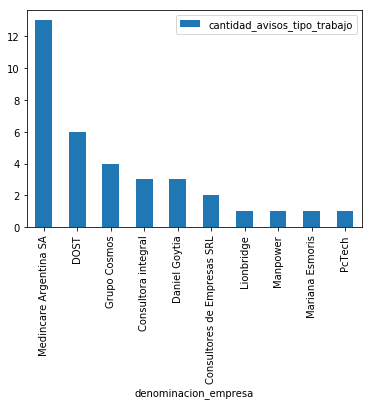

In [54]:
detalles_tipo_trabajo_full = detalles_tipo_trabajo[detalles_tipo_trabajo['tipo_de_trabajo'] == 'Full-time']
top_ten_empresas_full= detalles_tipo_trabajo_hora.sort_values(by='cantidad_avisos_tipo_trabajo',ascending=False)[:10]
top_ten_empresas_full.plot.bar(x = 'denominacion_empresa', y='cantidad_avisos_tipo_trabajo')

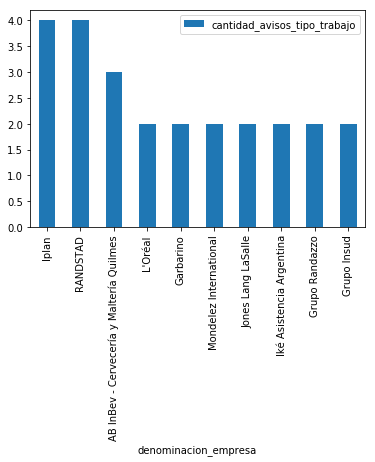

In [55]:
detalles_tipo_trabajo_pasantia = detalles_tipo_trabajo[detalles_tipo_trabajo['tipo_de_trabajo'] == 'Pasantia']
top_ten_empresas_pasantia= detalles_tipo_trabajo_pasantia.sort_values(by='cantidad_avisos_tipo_trabajo',ascending=False)[:10]
top_ten_empresas_pasantia.plot.bar(x = 'denominacion_empresa', y='cantidad_avisos_tipo_trabajo')

## Veamos cual es el area en el que se buscan mas juniors

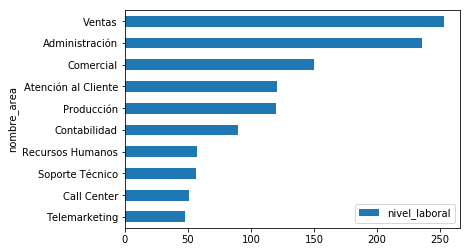

In [56]:
data_detalles[data_detalles['nivel_laboral'] == 'Junior'][['nivel_laboral','nombre_area']]\
                    .groupby('nombre_area')\
                    .count()\
                    .reset_index()\
                    .sort_values(by='nivel_laboral', ascending = False)\
                    [:10]\
                    [::-1]\
                    .plot\
                    .barh(x='nombre_area', y='nivel_laboral')

## Anuncios vistos por nivel laboral de acuerdo a la edad

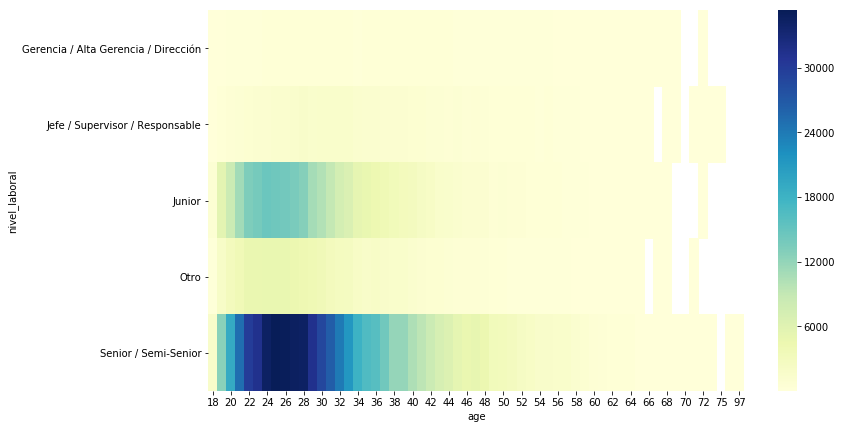

In [57]:
nivel_edad_count = postulantes_vistas_detalles[['age', 'nivel_laboral','idAviso']].groupby(['nivel_laboral','age']).count().reset_index()
nivel_edad_count.columns = ['nivel_laboral', 'age', 'count']
plt.figure(figsize = (12,7))
sns.heatmap(nivel_edad_count.pivot_table(index = 'nivel_laboral', columns = 'age', values = 'count'), cmap="YlGnBu")

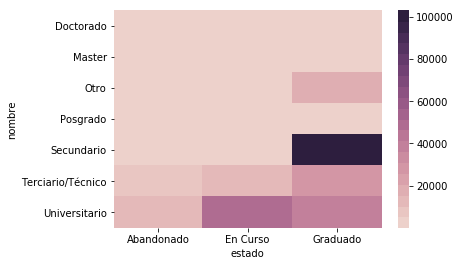

In [58]:
estado_educativo_postulante = data_carreras_fil.groupby(['nombre','estado']).count().reset_index()
estado_educativo_postulante.columns = ['nombre','estado','count']
sns.heatmap(estado_educativo_postulante.pivot_table(index='nombre',columns = 'estado', values='count'),cmap=sns.cubehelix_palette(20))

In [92]:
vistos_por_area = postulantes_vistas_detalles[['idAviso', 'nombre_area']].groupby('nombre_area').mean().reset_index()


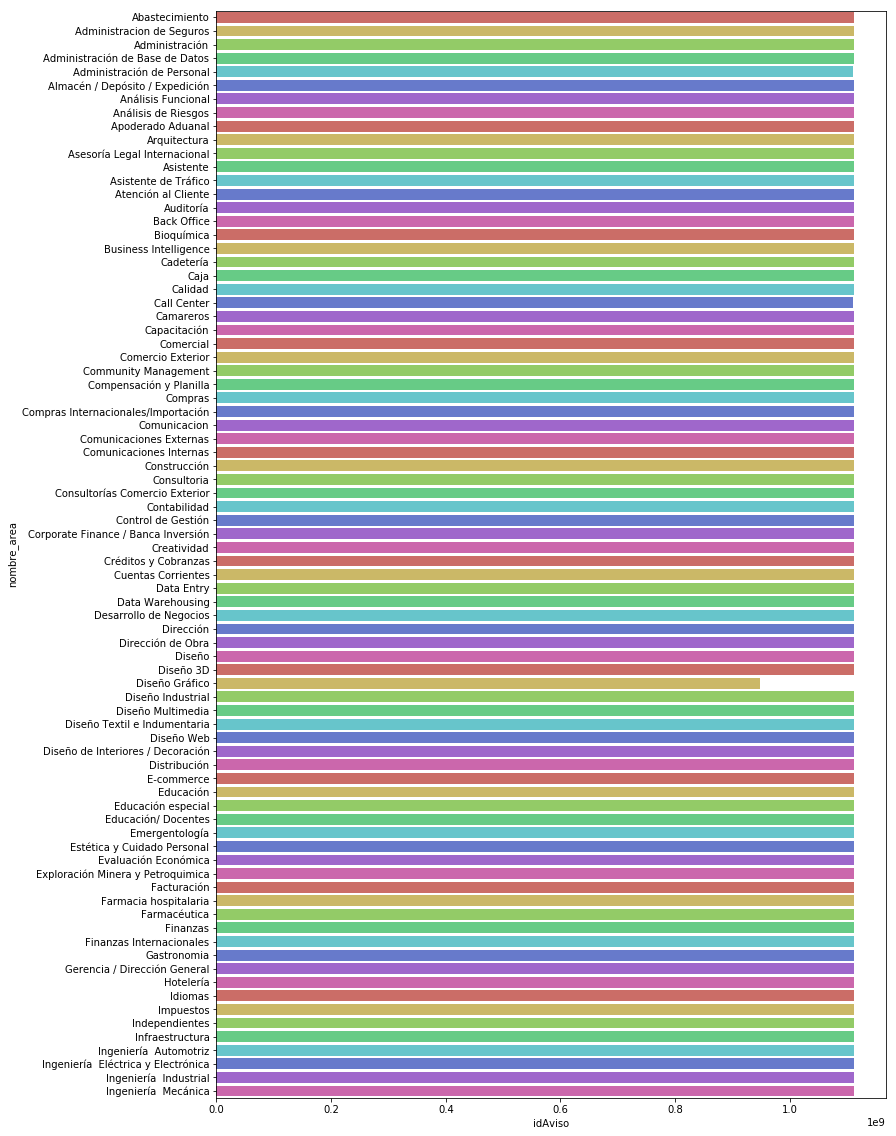

In [103]:
plt.figure(figsize = (12,20))
df_len = len(vistos_por_area)
sns.barplot(x='idAviso', y='nombre_area', data=vistos_por_area[:df_len//2], palette = sns.color_palette("hls", 8))

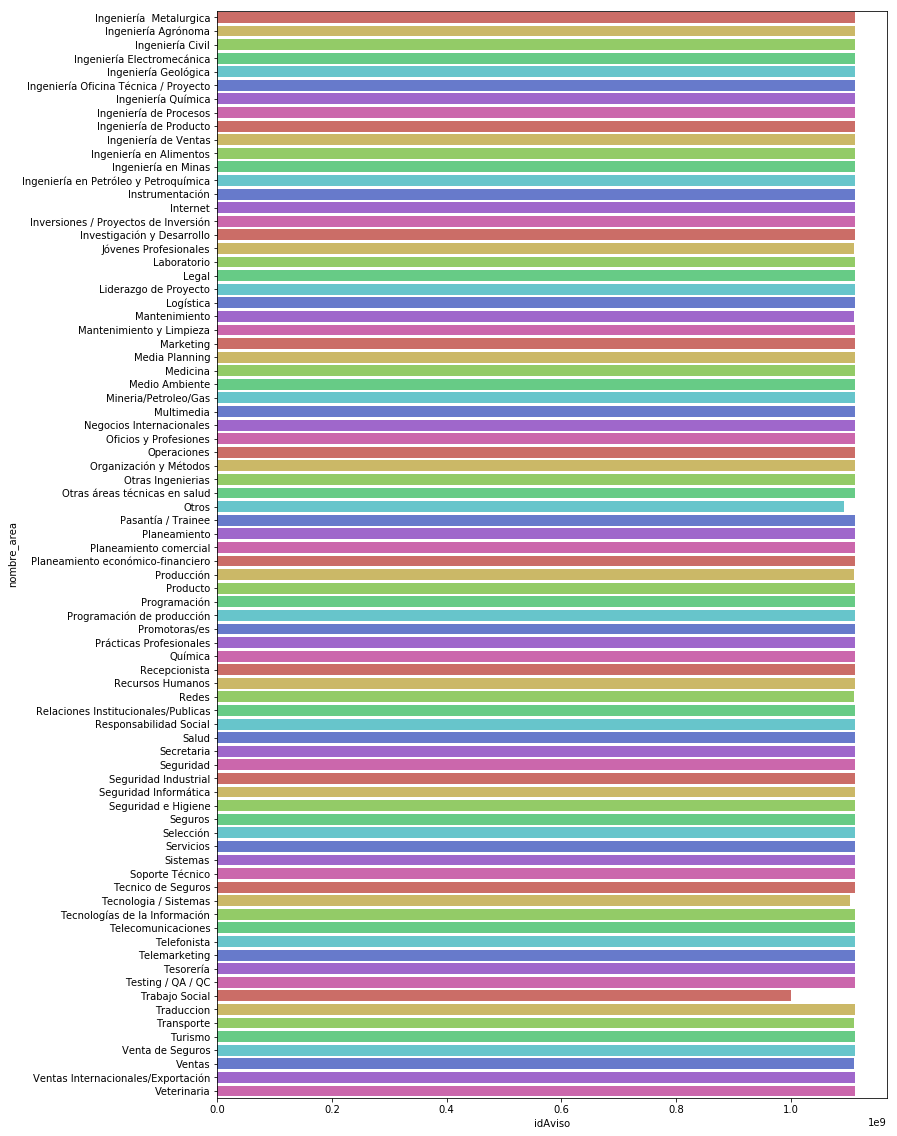

In [105]:
plt.figure(figsize = (12,20))
sns.barplot(x='idAviso', y='nombre_area', data=vistos_por_area[df_len//2:], palette = sns.color_palette("hls", 8))